In [1]:
%env CUDA_VISIBLE_DEVICES 3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import os
import json
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tqdm.notebook import tqdm

from data import create_train_and_valid_dataset, create_test_dataset
from data import CollateFn
from model import create_model

[nltk_data] Downloading package punkt to /home/sh0416/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


적절한 모델 찾기

In [3]:
metadatas = []
for param_fname in os.listdir("param"):
    param_fpath = os.path.join("param", param_fname)
    with open(param_fpath) as f:
        metadatas.append(json.load(f))

metadata_df = pd.DataFrame(data=metadatas)

target_records = metadata_df[(metadata_df["dataset"] == "ag_news")
                             & (metadata_df["augment"] == "adamix")
                             & (metadata_df["num_train_data"] == 2500)]
                             
target_records = target_records[["dataset", "num_train_data", "data_augment", "augment", "seed", "exp_id"]]
target_records.sort_values(["dataset", "num_train_data", "data_augment", "augment", "seed"])

,dataset,num_train_data,data_augment,augment,seed,exp_id
339,ag_news,2500,eda,adamix,0,e73bbf23
248,ag_news,2500,eda,adamix,1,31ded273
126,ag_news,2500,eda,adamix,2,4c7f29a8
171,ag_news,2500,eda,adamix,3,65f8d793
306,ag_news,2500,eda,adamix,4,05ec1a42
...,...,...,...,...,...,...
142,ag_news,2500,NaN,adamix,0,3d747ad5
412,ag_news,2500,NaN,adamix,1,7bac0d8d
425,ag_news,2500,NaN,adamix,2,628b1385
284,ag_news,2500,NaN,adamix,3,86d41093


In [4]:
max_length = 256

In [5]:
dataset = "ag_news"
data_dir = "/data/sh0416/dataset/pdistmix/ag_news_csv"
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
train_dataset, valid_dataset = create_train_and_valid_dataset(dataset=dataset,
                                               dirpath=data_dir,
                                               tokenizer=tokenizer,
                                               num_train_data=2500)
test_dataset = create_test_dataset(dataset=dataset,
                                   dirpath=data_dir,
                                   tokenizer=tokenizer)

collate_fn = CollateFn(tokenizer, max_length)
train_loader = DataLoader(train_dataset,
                          batch_size=256,
                          shuffle=True,
                          collate_fn=collate_fn)
test_loader = DataLoader(test_dataset,
                         batch_size=256,
                         shuffle=True,
                         collate_fn=collate_fn)

In [6]:
mixup_layer = 3
augment = "adamix"
device = torch.device("cuda")
intrusion_layer = 12
drop_prob = 0.1
model = create_model(augment=augment, 
                     mixup_layer=mixup_layer,
                     intrusion_layer=intrusion_layer,
                     n_class=test_dataset.n_class, 
                     n_layer=12, 
                     drop_prob=drop_prob)
model.load_state_dict(torch.load("ckpt/model_3d747ad5.pth"))
model.to(device)
print("complete")

complete


In [7]:
class Collector:
    def __init__(self):
        self.data = []
    
    def __call__(self, m, i, o):
        self.data.append(o.detach().cpu())

In [8]:
oommix_train_normal = Collector()
oommix_train_mix = Collector()

hook1 = model.sentence_h.register_forward_hook(oommix_train_normal)
hook2 = model.mix_sentence_h.register_forward_hook(oommix_train_mix)

train_labels, train_mixed_labels = [], []
with torch.no_grad():
    for batch in tqdm(train_loader):
        input_ids = batch["inputs"]["input_ids"].to(device)
        attention_mask = batch["inputs"]["attention_mask"].to(device)
        mixup_indices = torch.randperm(input_ids.shape[0], device=device)
        eps = torch.rand(input_ids.shape[0], device=device)
        outs, mix_outs, gamma, intr_loss = model(input_ids=input_ids, attention_mask=attention_mask,
                     mixup_indices=mixup_indices, eps=eps)
        gamma = gamma.cpu()
        #labels = batch["labels"]
        labels = torch.argmax(outs, 1)
        l = torch.zeros(labels.shape[0], test_dataset.n_class)
        l[range(labels.shape[0]), labels] = 1
        train_labels.append(l)
        #mix_l = gamma[:, None]*l + (1-gamma[:, None])*l[mixup_indices]
        labels = torch.argmax(mix_outs, 1)
        l = torch.zeros(labels.shape[0], test_dataset.n_class)
        l[range(labels.shape[0]), labels] = 1
        train_mixed_labels.append(l)

/home/sh0416/anaconda3/envs/python3.8/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [9]:
import numpy as np
oommix_train_normal_h = np.copy(torch.cat(oommix_train_normal.data, dim=0).numpy())
oommix_train_mix_h = np.copy(torch.cat(oommix_train_mix.data, dim=0).numpy())

In [10]:
hook1.remove()
hook2.remove()

In [11]:
oommix_test_normal = Collector()
hook3 = model.sentence_h.register_forward_hook(oommix_test_normal)

In [12]:
from tqdm.notebook import tqdm

test_labels = []
with torch.no_grad():
    model.eval()
    for idx, batch in tqdm(enumerate(test_loader)):
        input_ids = batch["inputs"]["input_ids"].to(device)
        attention_mask = batch["inputs"]["attention_mask"].to(device)
        outs = model(input_ids=input_ids,
                     attention_mask=attention_mask)
        labels = torch.argmax(outs, 1)
        l = torch.zeros(labels.shape[0], test_dataset.n_class)
        l[range(labels.shape[0]), labels] = 1
        test_labels.append(l)
        if idx == 8:
            break

In [13]:
oommix_test_normal_h = np.copy(torch.cat(oommix_test_normal.data, dim=0).numpy())

In [14]:
train_l = torch.cat(train_labels, dim=0)
train_mix_l = torch.cat(train_mixed_labels, dim=0)
test_l = torch.cat(test_labels, dim=0)

In [15]:
import numpy as np
idx = np.random.randint(oommix_train_normal_h.shape[0], size=1000)
idx2 = np.random.randint(oommix_train_mix_h.shape[0], size=1000)
idx3 = np.random.randint(oommix_test_normal_h.shape[0], size=1000)

sample_oommix_train_normal_h = oommix_train_normal_h[idx]
sample_oommix_train_mix_h = oommix_train_mix_h[idx2]
sample_oommix_test_normal_h = oommix_test_normal_h[idx3]
sample_train_l, sample_train_mix_l, sample_test_l = train_l[idx], train_mix_l[idx2], test_l[idx3]
#sample_h, sample_h2, sample_h3 = h, h2, h3

In [16]:
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA

X = np.concatenate((sample_oommix_train_normal_h,
                    sample_oommix_train_mix_h,
                    sample_oommix_test_normal_h), axis=0)
#X = np.concatenate((sample_oommix_train_mix_h,
#                    sample_oommix_test_normal_h), axis=0)

isomap = Isomap(n_components=3, n_neighbors=25)
result = isomap.fit_transform(X)
#tsne = TSNE(n_components=3, perplexity=30)
#result = tsne.fit_transform(X)
#pca = PCA(n_components=2)
#result = pca.fit_transform(X)

              x          y          z  \
0    -16.396971   0.660955 -10.333487   
1     -5.848743 -26.463878  14.603323   
2    -16.366193  27.146735   8.035279   
3     -8.399645 -18.106111  11.360565   
4     -4.676024  -3.729051 -18.273816   
...         ...        ...        ...   
2995 -10.048096  -2.563970 -20.762373   
2996  -3.545904   4.349008 -24.042143   
2997  -8.695446  -0.808280  -8.979594   
2998 -21.979980  24.767247  13.645693   
2999 -13.729794  -4.054457  -8.320746   

                                                  label    type  
0     [0.17254901960784313, 0.6274509803921569, 0.17...  normal  
1     [0.12156862745098039, 0.4666666666666667, 0.70...  normal  
2       [1.0, 0.4980392156862745, 0.054901960784313725]  normal  
3     [0.12156862745098039, 0.4666666666666667, 0.70...  normal  
4     [0.8392156862745098, 0.15294117647058825, 0.15...  normal  
...                                                 ...     ...  
2995  [0.8392156862745098, 0.1529411764705882

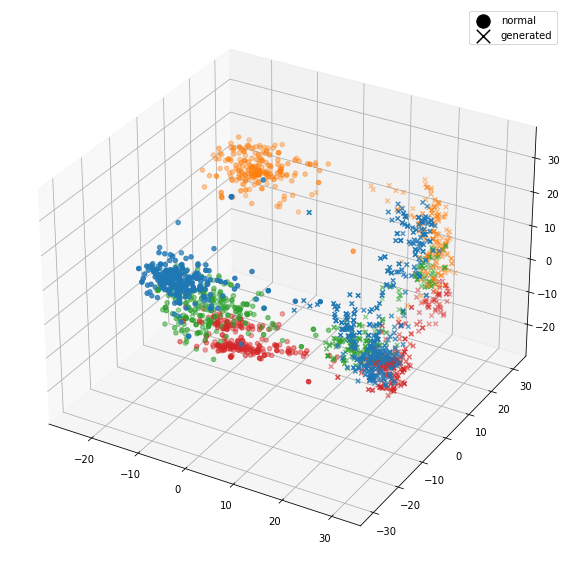

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rgb_list = list(sns.color_palette("tab10"))

def get_color_list(label_list):
    clist = []
    for x in label_list:
        c = [0, 0, 0]
        for i, y in enumerate(x):
            c[0] += y * rgb_list[i][0]
            c[1] += y * rgb_list[i][1]
            c[2] += y * rgb_list[i][2]
        clist.append(c)
    return clist

clist = []
clist.extend(get_color_list(sample_train_l.tolist()))
clist.extend(get_color_list(sample_train_mix_l.tolist()))
clist.extend(get_color_list(sample_test_l.tolist()))

df1 = pd.DataFrame(data=result, columns=["x", "y", "z"])
df1["label"] = clist
df1["type"] = ["normal" for i in sample_train_l.tolist()] + \
              ["generated" for _ in range(sample_oommix_train_mix_h.shape[0])] + \
              ["test" for i in sample_test_l.tolist()]
#df1["label"] = ["oommix" for _ in range(sample_oommix_train_mix_h.shape[0])] + \
#               ["class %d" % i for i in sample_test_l.tolist()]
#df1["type"] = ["train" for _ in range(sample_oommix_train_mix_h.shape[0])] + \
#              ["test" for i in sample_test_l.tolist()]
print(df1)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
#sns.set_theme(context="paper", style="ticks", font_scale=1.5)
#fig, ax = plt.subplots(figsize=(8, 8), ncols=1)
#g = sns.scatterplot(x="x", y="y", style="type", style_order=["normal", "generated", "test"],
#data=df1, s=20, ax=ax, c=df1["label"])

a=ax.scatter(df1[df1["type"]=="normal"]["x"],
           df1[df1["type"]=="normal"]["y"],
           df1[df1["type"]=="normal"]["z"],
           c=df1[df1["type"]=="normal"]["label"],
           marker='o')

b=ax.scatter(df1[df1["type"]=="generated"]["x"],
           df1[df1["type"]=="generated"]["y"],
           df1[df1["type"]=="generated"]["z"],
           c=df1[df1["type"]=="generated"]["label"],
           marker='x')

"""
c=ax.scatter(df1[df1["type"]=="test"]["x"],
           df1[df1["type"]=="test"]["y"],
           df1[df1["type"]=="test"]["z"],
           c=df1[df1["type"]=="test"]["label"],
           marker='*')
"""

ax.legend((a, b), ("normal", "generated"), markerscale=3)
ax.get_legend().legendHandles[0].set_color("black")
ax.get_legend().legendHandles[1].set_color("black")
    # You can also use lh.set_sizes([50])
#sns.scatterplot(x=0, y=1, style="type", style_order=["test", "train"],
#                data=df1[df1["label"]!="oommix"], s=100, ax=axes[1])
#sns.scatterplot(x=0, y=1, hue="label", style="type", style_order=["test", "train"], data=df1, s=50)
"""
sns.scatterplot(x=result[:500, 0], y=result[:500, 1], hue=y[:500],
                hue_order=["train class 0", "train class 1", "train class 2", "train class 3"], ax=ax, s=20)
sns.scatterplot(x=result[500:1000, 0], y=result[500:1000, 1], color='.2', ax=ax, s=20)
sns.scatterplot(x=result[1000:, 0], y=result[1000:, 1], hue=y[1000:],
                hue_order=["test class 0", "test class 1", "test class 2", "test class 3"], markers=True, ax=ax, s=40)
"""
plt.tight_layout()
plt.savefig(os.path.join("res", "exp5.png"))


In [ ]:
oommix_train_normal_h.shape

In [ ]:
import numpy as np
with torch.no_grad():
    model2.to(device)
    model2.eval()
    for batch in tqdm(test_loader):
        input_ids = batch["inputs"]["input_ids"].to(device)
        attention_mask = batch["inputs"]["attention_mask"].to(device)
        mixup_indices = torch.randperm(input_ids.shape[0], device=device)
        lambda_ = np.random.beta(0.1, 0.1)
        lambda_ = torch.tensor(np.where(lambda_>=0.5, lambda_, 1-lambda_), device=device)
        outs = model2(input_ids=input_ids,
                     attention_mask=attention_mask,
                     mixup_indices=mixup_indices,
                     lambda_=lambda_)

In [ ]:
h = torch.cat(normal_collector.data, dim=0)
h2 = torch.cat(oommix_collector.data, dim=0)
h3 = torch.cat(mix_collector.data, dim=0)

In [ ]:
h = h.numpy()
h2 = h2.numpy()
h3 = h3.numpy()

In [ ]:
l = torch.cat(labels, dim=0)

In [ ]:
import numpy as np
idx = np.random.randint(h.shape[0], size=500)

sample_h, sample_h2, sample_h3 = h[idx], h2[idx], h3[idx]
sample_l = l[idx]
#sample_h, sample_h2, sample_h3 = h, h2, h3

In [ ]:
import scipy as scp
dist = scp.spatial.distance.pdist(np.concatenate((sample_h, sample_h2), axis=0), metric="euclidean")

In [ ]:
square = scp.spatial.distance.squareform(dist)

In [ ]:
between = square[:500, 500:].flatten()
within = square[:500, :500].flatten()

In [ ]:
import pandas as pd

between_df = pd.DataFrame(data=between)
between_df["type"] = "in-out"
within_df = pd.DataFrame(data=within)
within_df["type"] = "in-in"

In [ ]:
df = pd.concat((between_df, within_df))

In [ ]:
import seaborn as sns
sns.displot(data=df, x=0, hue="type")

In [ ]:
dist.shape

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(square, cmap=sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True), ax=ax)

In [ ]:
h.shape, h2.shape, h3.shape

In [ ]:
import numpy as np
idx = np.random.randint(h.shape[0], size=500)
idx2 = np.random.randint(h.shape[0], size=1500)
idx3 = np.random.randint(h.shape[0], size=100)
sample_h, sample_h2, sample_h3 = h[idx], h2[idx2], h3[idx3]
sample_l = l[idx]
#sample_h, sample_h2, sample_h3 = h, h2, h3

In [ ]:
X = np.concatenate((sample_h, sample_h2, sample_h3), axis=0)

from sklearn.manifold import TSNE, Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA

tsne = TSNE(perplexity=20)
result = tsne.fit_transform(X)
#isomap = Isomap(n_components=2)
#result = isomap.fit_transform(X)
#pca = PCA(n_components=2)
#result = pca.fit_transform(X)
#lle = LocallyLinearEmbedding(n_components=2, n_neighbors=50)
#result = lle.fit_transform(X)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
y = ["class %d" % i for i in sample_l.tolist()] + \
    ["oommix" for _ in range(sample_h2.shape[0])] + \
    ["tmix" for _ in range(sample_h3.shape[0])]
sns.set_theme(context="paper", style="ticks", font_scale=1.5)
fig, axes = plt.subplots(figsize=(16, 8), ncols=2)
sns.scatterplot(x=result[:500, 0], y=result[:500, 1], hue=y[:500],
                hue_order=["class 0", "class 1", "class 2", "class 3"], ax=axes[0], s=20)
sns.scatterplot(x=result[2000:, 0], y=result[2000:, 1], color='.2', ax=axes[0], s=20)
sns.scatterplot(x=result[:500, 0], y=result[:500, 1], hue=y[:500],
                hue_order=["class 0", "class 1", "class 2", "class 3"], ax=axes[1], s=20)
sns.scatterplot(x=result[500:2000, 0], y=result[500:2000, 1], color='.2', ax=axes[1], s=20)
plt.savefig("exp5.png")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="paper", style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=y, ax=ax, s=5)

In [ ]:
X = np.concatenate((sample_h, sample_h2), axis=0)
y = ["normal" for _ in range(sample_h.shape[0])] + \
    ["oommix" for _ in range(sample_h2.shape[0])] 

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=5)
result = tsne.fit_transform(X)

In [ ]:
import seaborn as sns

sns.set_theme(context="paper", style="ticks", font_scale=1.5)
sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=y)

In [ ]:
X = np.concatenate((sample_h, sample_h3), axis=0)
y = ["normal" for _ in range(sample_h.shape[0])] + \
    ["mix coeff: 0.5" for _ in range(sample_h3.shape[0])]
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=5)
result = tsne.fit_transform(X)

In [ ]:
import seaborn as sns

sns.set_theme(context="paper", style="ticks", font_scale=1.5)
sns.scatterplot(x=result[:, 0], y=result[:, 1], hue=y)

In [ ]:
with torch.no_grad():
    gammas = []
    intr_loss_mean, c = 0, 0
    model.eval()
    for batch in test_loader:
        input_ids = batch["inputs"]["input_ids"].to(device)
        attention_mask = batch["inputs"]["attention_mask"].to(device)
        mixup_indices = torch.randperm(input_ids.shape[0], device=device)
        eps = torch.rand(input_ids.shape[0], device=device)
        outs, mix_outs, gamma, intr_loss = model(input_ids=input_ids,
                                             attention_mask=attention_mask,
                                             mixup_indices=mixup_indices,
                                             eps=eps)
        gammas.append(gamma)
        intr_loss_mean += intr_loss.item()
        c += 1
    gammas = torch.cat(gammas)
    intr_loss_mean /= c

In [ ]:
intr_loss_mean

In [ ]:
intr_loss_mean

In [ ]:
o = torch.cat(olist, dim=0)

In [ ]:
o

In [ ]:
o.shape

In [ ]:
ag_news_gammas

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="paper", style="ticks", font_scale=1.5)
sns.distplot(o[:, 0].cpu().numpy(), hist=False)

In [ ]:
ax = sns.distplot(gammas.cpu().numpy(), hist=False)
ax.set(xlabel="mixing coefficient",
       xlim=(0, 1))
plt.savefig("exp3_ag_news_success.png")

In [ ]:
gammas.shape

In [ ]:
intr_loss

In [ ]:



    if torch.cuda.is_available():
        torch.cuda.set_device(args.gpu)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(torch.cuda.current_device())
    
    model.to(device)
    
    test_acc = evaluate(model, test_loader, device)
    for k, v in vars(args).items():
        logging.info("Parameter %s = %s" % (k, str(v)))
    logging.info("Test accuracy: %.4f" % test_acc)

    os.makedirs("param", exist_ok=True)
    with open(os.path.join("param", args.exp_id+".json"), 'w') as f:
        json.dump(vars(args), f, indent=2)

In [ ]:
model2 = create_model(augment="tmix", 
                     mixup_layer=mixup_layer,
                     intrusion_layer=intrusion_layer,
                     n_class=test_dataset.n_class, 
                     n_layer=12, 
                     drop_prob=drop_prob)
model2.load_state_dict(torch.load("ckpt/model_f4f149ec.pth"))